# Sistema de recomendación Spotify

# Análisis exploratorio

### Librerias generales

#### Instalar e importar librerías necesarias

1. Correr el siguiente comando 

```bash
pip install -r requirements.txt
```

In [16]:
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
from tqdm import tqdm

### Librerías de ML

In [14]:
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor

import ipywidgets as widgets
widgets.IntSlider()
from tqdm.notebook import tqdm



print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.4.1; Torch-cuda version: None; Torch Geometric version: 2.6.1.


Creación de una semilla

In [5]:
# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Cargar y procesar los datos

Link de los datos https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge/dataset_files

In [6]:
DATA_DIR = "./spotify_million_playlist_dataset/data/"

In [7]:
with open(f"{DATA_DIR}/{os.listdir(DATA_DIR)[0]}") as jf:
  example_file = json.load(jf)

print(example_file['playlists'][0])

{'name': 'Bob Dylan', 'collaborative': 'false', 'pid': 549000, 'modified_at': 1454803200, 'num_tracks': 75, 'num_albums': 65, 'num_followers': 1, 'tracks': [{'pos': 0, 'artist_name': 'Bob Dylan', 'track_uri': 'spotify:track:6QHYEZlm9wyfXfEM1vSu1P', 'artist_uri': 'spotify:artist:74ASZWbe4lXaubB36ztrGX', 'track_name': 'Boots of Spanish Leather', 'album_uri': 'spotify:album:7DZeLXvr9eTVpyI1OlqtcS', 'duration_ms': 277106, 'album_name': "The Times They Are A-Changin'"}, {'pos': 1, 'artist_name': 'Bob Dylan', 'track_uri': 'spotify:track:3RkQ3UwOyPqpIiIvGVewuU', 'artist_uri': 'spotify:artist:74ASZWbe4lXaubB36ztrGX', 'track_name': 'Mr. Tambourine Man', 'album_uri': 'spotify:album:1lPoRKSgZHQAYXxzBsOQ7v', 'duration_ms': 330533, 'album_name': 'Bringing It All Back Home'}, {'pos': 2, 'artist_name': 'Loggins & Messina', 'track_uri': 'spotify:track:0ju1jP0cSPJ8tmojYBEI89', 'artist_uri': 'spotify:artist:7emRV8AluG3d4e5T0DZiK9', 'track_name': "Danny's Song", 'album_uri': 'spotify:album:5BWgJaesMjpJWC

In [8]:
"""
Aquí definimos clases para los datos que vamos a cargar. Los datos están almacenados en archivos JSON,
cada uno de los cuales contiene playlists, que a su vez contienen canciones. Así, definimos tres clases:
  Cancion     --> contiene información sobre una canción específica (su id, nombre, etc.)
  Playlist    --> contiene información sobre una playlist específica (su id, nombre, etc. y una lista de Canciones)
  ArchivoJSON --> contiene el archivo JSON cargado y almacena un diccionario de todas las playlists

Nota: si quisiéramos utilizar la información del artista, podríamos crear una clase Artista
"""

class Cancion:
    """ 
    Clase simple para una canción, que contiene sus atributos:
        1. URI (un id único)
        2. Nombre
        3. Información del artista (URI y nombre)
        4. Playlist a la que pertenece
    """
    
    def __init__(self, datos_cancion, playlist):
        self.uri = datos_cancion["track_uri"]
        self.nombre = datos_cancion["track_name"]
        self.artista_uri = datos_cancion["artist_uri"]
        self.artista_nombre = datos_cancion["artist_name"]
        self.playlist = playlist
    
    def __str__(self):
        return f"Canción {self.uri} llamada {self.nombre} por {self.artista_nombre} ({self.artista_uri}) en la playlist {self.playlist}."
    
    def __repr__(self):
        return f"Canción {self.uri}"

class Playlist:
    """ 
    Clase simple para una playlist, que contiene sus atributos:
        1. Nombre (playlist y su índice asociado)
        2. Título (título de la playlist en el dataset de Spotify)
        3. Diccionario cargado desde el JSON original para la playlist
        4. Diccionario de canciones (track_uri : Cancion), que se llena con el método .cargar_canciones()
        5. Lista de URIs de artistas
    """
    
    def __init__(self, datos_json, indice):
        self.nombre = f"playlist_{indice}"
        self.titulo = datos_json["name"]
        self.datos = datos_json

        self.canciones = {}
        self.artistas = []
    
    def cargar_canciones(self):
        """ Llama a esta función para cargar todas las canciones en la playlist desde los datos del JSON. """

        lista_canciones = self.datos["tracks"]
        self.canciones = {x["track_uri"] : Cancion(x, self.nombre) for x in lista_canciones}
        self.artistas = [x["artist_uri"] for x in lista_canciones]

    def __str__(self):
        return f"Playlist {self.nombre} con {len(self.canciones)} canciones cargadas."
    
    def __repr__(self):
        return f"Playlist {self.nombre}"

class ArchivoJSON:
    """ 
    Clase simple para un archivo JSON, que contiene sus atributos:
        1. Nombre del archivo
        2. Índice desde el cual comenzar a numerar las playlists
        3. Diccionario cargado desde el JSON para todo el archivo
        4. Diccionario de playlists (nombre : Playlist), que se llena con el método .procesar_archivo()
    """
    
    def __init__(self, ruta_datos, nombre_archivo, indice_inicio):
        self.nombre_archivo = nombre_archivo
        self.indice_inicio = indice_inicio

        with open(os.path.join(ruta_datos, nombre_archivo)) as archivo_json:
            datos_json = json.load(archivo_json)
        self.datos = datos_json

        self.playlists = {}

    def procesar_archivo(self):
        """ Llama a esta función para cargar todas las playlists desde los datos del archivo JSON. """
        
        for i, playlist_json in enumerate(self.datos["playlists"]):
            playlist = Playlist(playlist_json, self.indice_inicio + i)
            playlist.cargar_canciones()
            self.playlists[playlist.nombre] = playlist

    def __str__(self):
        return f"JSON {self.nombre_archivo} tiene {len(self.playlists)} playlists cargadas."
    
    def __repr__(self):
        return self.nombre_archivo


Cargar los archivos json 

In [17]:
# Cargar cada archivo JSON y almacenarlo en una lista de archivos
archivos_JSON = []
for nombre_archivo in tqdm(archivos_a_usar, desc='Archivos procesados: ', unit='archivos', total=len(archivos_a_usar)):
    archivo_json = ArchivoJSON(RUTA_DATOS, nombre_archivo, n_playlists)
    archivo_json.procesar_archivo()
    n_playlists += len(archivo_json.playlists)
    archivos_JSON.append(archivo_json)





Exception ignored in: <function tqdm.__del__ at 0x123a26980>
Traceback (most recent call last):
  File "/Users/mvrcentes/Library/CloudStorage/OneDrive-UVG/Documentos/Semestre_8/Data_Science/Data_Science_2024/myvenv/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/mvrcentes/Library/CloudStorage/OneDrive-UVG/Documentos/Semestre_8/Data_Science/Data_Science_2024/myvenv/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x123a26980>
Traceback (most recent call last):
  File "/Users/mvrcentes/Library/CloudStorage/OneDrive-UVG/Documentos/Semestre_8/Data_Science/Data_Science_2024/myvenv/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/mvrcentes/Library/CloudStorage/OneDrive-UVG/Documentos/Semestre_8/Data_S

In [19]:
playlist_data = {}
playlists = []
tracks = []

# Construir la lista de todas las playlists y pistas únicas
for archivo_json in tqdm(archivos_JSON, desc='Procesando archivos JSON: ', unit='archivo'):
    # Agregar los nombres de las playlists
    playlists += [p.nombre for p in archivo_json.playlists.values()]
    
    # Agregar los URI de las canciones
    tracks += [cancion.uri for playlist in archivo_json.playlists.values() for cancion in playlist.canciones.values()]
    
    # Combinar los datos de las playlists en el diccionario principal
    playlist_data = playlist_data | archivo_json.playlists


Procesando archivos JSON: 100%|██████████| 50/50 [00:01<00:00, 48.71archivo/s]


## Creación de un dataframe con los datos cargados

In [20]:
canciones_data = []

for archivo_json in archivos_JSON:
    for playlist in archivo_json.playlists.values():
        for cancion in playlist.canciones.values():
            canciones_data.append({
                'playlist_nombre': playlist.nombre,
                'playlist_titulo': playlist.titulo,
                'track_uri': cancion.uri,
                'track_nombre': cancion.nombre,
                'artista_uri': cancion.artista_uri,
                'artista_nombre': cancion.artista_nombre
            })

# Convertir la lista de diccionarios en un DataFrame de pandas
df = pd.DataFrame(canciones_data)

## Descripción de los datos

In [21]:
# Mostrar las primeras filas del DataFrame
print(df.head(1))


  playlist_nombre playlist_titulo                             track_uri  \
0      playlist_0      Throwbacks  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI   

                                 track_nombre  \
0  Lose Control (feat. Ciara & Fat Man Scoop)   

                             artista_uri artista_nombre  
0  spotify:artist:2wIVse2owClT7go1WT98tk  Missy Elliott  


In [22]:
df.describe()


,playlist_nombre,playlist_titulo,track_uri,track_nombre,artista_uri,artista_nombre
count,3303932,3303932,3303932,3303932,3303932,3303932
unique,50000,18965,457016,332916,79189,78079
top,playlist_8520,Country,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,Closer,spotify:artist:3TVXtAsR1Inumwj472S9r4,Drake
freq,250,65893,2252,3342,42345,42360


1. Cantidad de Datos (Count):
* Todas las columnas (playlist_nombre, playlist_titulo, track_uri, track_nombre, artista_uri, y artista_nombre) contienen 3,303,932 entradas, lo que significa que tenemos información detallada sobre más de 3.3 millones de pistas musicales distribuidas en diferentes playlists.

2. Variables Categóricas y Únicas (Unique):
* Playlist Nombre: Hay un total de 50,000 playlists únicas en el conjunto de datos, lo que significa que algunas playlists contienen múltiples canciones y posiblemente estén repetidas en otros lugares.
* Playlist Título: Hay 18,965 títulos únicos de playlists. Esto indica que algunas playlists comparten nombres pero contienen diferentes canciones.
* Track URI: Existen 457,016 pistas únicas en el conjunto de datos. Esto sugiere que muchas pistas están repetidas en distintas playlists, lo cual es común en plataformas de streaming, donde una misma canción puede aparecer en varias listas de reproducción.
* Track Nombre: Se identifican 332,916 títulos de canciones únicas, lo que indica que algunas pistas pueden compartir nombres pero ser versiones diferentes (por ejemplo, remixes o colaboraciones).
* Artista URI: Hay 79,189 artistas únicos en el dataset.
* Artista Nombre: Los nombres de artista únicos son 78,079, lo que indica una leve diferencia con los URIs de artistas, posiblemente debido a inconsistencias en el etiquetado o distintas versiones de los nombres de los artistas.

3. Frecuencia y Popularidad:
* La playlist más frecuente es playlist_8520, que aparece 250 veces en el conjunto de datos, siendo la playlist más recurrente.
* El título de playlist más frecuente es "Country", que aparece 65,893 veces, indicando una alta popularidad de playlists relacionadas con este género.
* La pista más repetida es "Closer" (URI: spotify:track:7KXjTSCq5nL1LoYtL7XAwS), que aparece 2,252 veces en distintas playlists.
* El artista más frecuente es Drake (URI: spotify:artist:3TVXtAsR1Inumwj472S9r4), cuyas canciones aparecen 42,360 veces en las playlists.



In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3303932 entries, 0 to 3303931
Data columns (total 6 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   playlist_nombre  object
 1   playlist_titulo  object
 2   track_uri        object
 3   track_nombre     object
 4   artista_uri      object
 5   artista_nombre   object
dtypes: object(6)
memory usage: 151.2+ MB


In [27]:
for column in df.select_dtypes(include='object').columns:
    print(f"Columna: {column}")
    print(df[column].apply(type).value_counts())


Columna: playlist_nombre
playlist_nombre
<class 'str'>    3303932
Name: count, dtype: int64
Columna: playlist_titulo
playlist_titulo
<class 'str'>    3303932
Name: count, dtype: int64
Columna: track_uri
track_uri
<class 'str'>    3303932
Name: count, dtype: int64
Columna: track_nombre
track_nombre
<class 'str'>    3303932
Name: count, dtype: int64
Columna: artista_uri
artista_uri
<class 'str'>    3303932
Name: count, dtype: int64
Columna: artista_nombre
artista_nombre
<class 'str'>    3303932
Name: count, dtype: int64


In [28]:
# Verificar si todas las entradas en las columnas de tipo 'object' son cadenas de texto
for column in df.select_dtypes(include='object').columns:
    all_strings = df[column].apply(lambda x: isinstance(x, str)).all()
    if all_strings:
        print(f"Todas las entradas en la columna '{column}' son cadenas de texto.")
    else:
        print(f"Algunas entradas en la columna '{column}' no son cadenas de texto.")


Todas las entradas en la columna 'playlist_nombre' son cadenas de texto.
Todas las entradas en la columna 'playlist_titulo' son cadenas de texto.
Todas las entradas en la columna 'track_uri' son cadenas de texto.
Todas las entradas en la columna 'track_nombre' son cadenas de texto.
Todas las entradas en la columna 'artista_uri' son cadenas de texto.
Todas las entradas en la columna 'artista_nombre' son cadenas de texto.


In [29]:
# Ejemplo: Convertir una columna a tipo numérico si es necesario
df['track_uri'] = pd.to_numeric(df['track_uri'], errors='ignore')  # Solo si tiene números


/var/folders/h8/k3gpg6h97wv_mzlyws73msh80000gn/T/ipykernel_24091/41059988.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df['track_uri'] = pd.to_numeric(df['track_uri'], errors='ignore')  # Solo si tiene números


## Limpieza de datos

In [24]:
# Encontrar columnas con valores nulos
null_columns = df.isnull().sum()

# Mostrar los resultados de las columnas con valores nulos
print(null_columns)

# Eliminar filas duplicadas en todo el DataFrame
df.drop_duplicates(inplace=True)

# Rellenar valores nulos en las columnas 'playlist_nombre' y 'artista_nombre' con el valor anterior
df['playlist_nombre'].fillna(method='ffill', inplace=True)
df['artista_nombre'].fillna(method='ffill', inplace=True)

# Verificar si aún quedan valores nulos
print(df.isnull().sum())


playlist_nombre    0
playlist_titulo    0
track_uri          0
track_nombre       0
artista_uri        0
artista_nombre     0
dtype: int64


/var/folders/h8/k3gpg6h97wv_mzlyws73msh80000gn/T/ipykernel_24091/343811935.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['playlist_nombre'].fillna(method='ffill', inplace=True)
/var/folders/h8/k3gpg6h97wv_mzlyws73msh80000gn/T/ipykernel_24091/343811935.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['playlist_nombre'].fillna(method='ffill', inplace=True)
/var/folders/h8/k3gpg6h97wv_mzlyws73msh80000gn/T/ipykernel_24091/3438

playlist_nombre    0
playlist_titulo    0
track_uri          0
track_nombre       0
artista_uri        0
artista_nombre     0
dtype: int64


In [26]:
df.shape

(3303932, 6)

## Gráficos

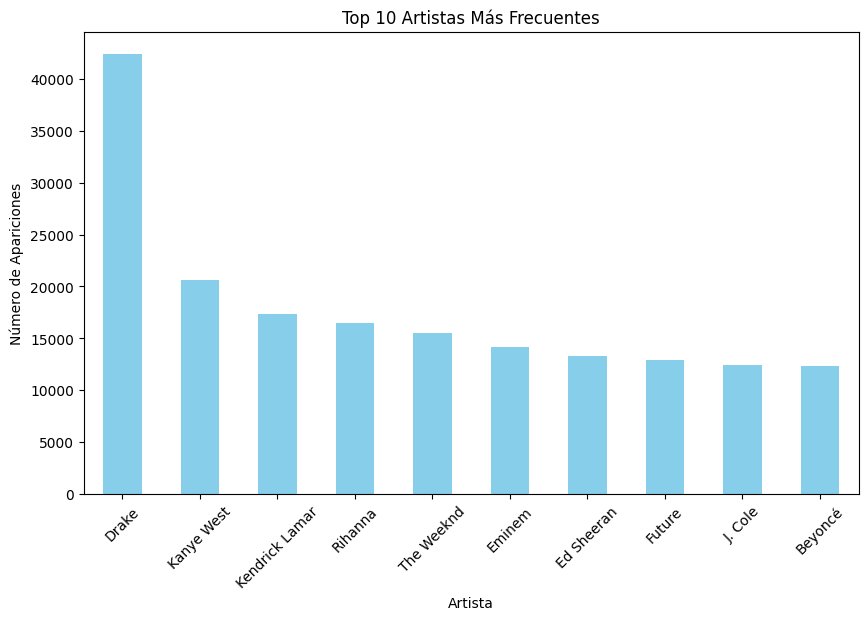

In [32]:
# Contar las apariciones de cada artista
artista_frecuencia = df['artista_nombre'].value_counts().head(10)  # Top 10 artistas

# Gráfico de barras para los artistas más frecuentes
plt.figure(figsize=(10, 6))
artista_frecuencia.plot(kind='bar', color='skyblue')
plt.title('Top 10 Artistas Más Frecuentes')
plt.xlabel('Artista')
plt.ylabel('Número de Apariciones')
plt.xticks(rotation=45)
plt.show()

En este gráfico de barras se presenta la frecuencia de los 10 artistas más populares en las playlists analizadas del dataset de Spotify. Los datos muestran claramente la dominancia de ciertos artistas en las playlists, y se pueden hacer las siguientes observaciones:

1. Drake es el artista más frecuente: Con más de 40,000 apariciones, Drake se destaca significativamente por encima de otros artistas. Este hallazgo resalta su popularidad y presencia en múltiples listas de reproducción de los usuarios de Spotify. Su frecuencia es casi el doble que el segundo artista más frecuente, Kanye West, lo que refuerza su posición en el mainstream musical.

2. Distribución de los artistas: Después de Drake, hay un grupo de artistas con una frecuencia más baja, pero que siguen siendo populares. Entre ellos están Kanye West, Kendrick Lamar, Rihanna y The Weeknd, todos con más de 15,000 apariciones en las playlists. Esto demuestra su relevancia y cuán frecuentes son en la creación de playlists.

3. Tendencias de género y estilo: Los artistas que aparecen en este top 10 son predominantemente de géneros como el hip-hop, R&B y pop. Esto sugiere que las playlists de Spotify tienen una inclinación hacia estos estilos musicales, lo cual podría estar reflejando una tendencia en las preferencias de los usuarios.

4. Eminem, Ed Sheeran, y Future tienen una presencia considerable: Aunque su frecuencia es menor que la de los artistas mencionados anteriormente, estos tres músicos mantienen una popularidad constante en las playlists. Ed Sheeran y Beyoncé, siendo artistas más ligados al pop y R&B, muestran también que hay una diversidad de géneros dentro de las listas.

5. Beyoncé como única artista femenina en el top 10: Aunque Rihanna tiene una frecuencia similar, Beyoncé es la única mujer que entra en el top 10 de los artistas más frecuentes. Este dato podría sugerir una diferencia de representación en cuanto a género en las playlists populares.

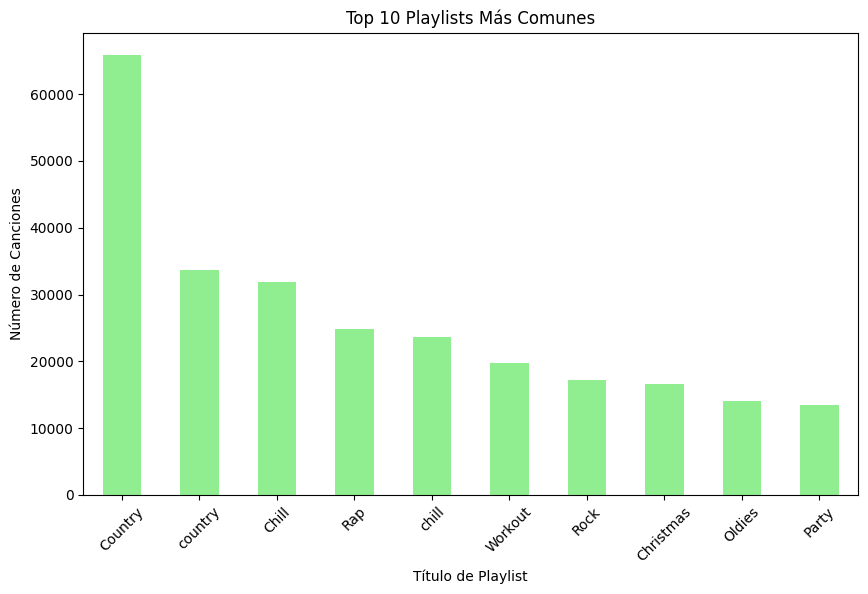

In [34]:
# Contar las apariciones de cada playlist
playlist_frecuencia = df['playlist_titulo'].value_counts().head(10)  # Top 10 playlists

# Gráfico de barras para las playlists más frecuentes
plt.figure(figsize=(10, 6))
playlist_frecuencia.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Playlists Más Comunes')
plt.xlabel('Título de Playlist')
plt.ylabel('Número de Canciones')
plt.xticks(rotation=45)
plt.show()


En este gráfico de barras, se muestra la frecuencia de los títulos de las playlists más comunes en el dataset de Spotify. A continuación, se explican los hallazgos principales:

1. Dominancia del género "Country": Se observa que el título de playlist "Country" es, por mucho, el más frecuente, con más de 60,000 apariciones. Esto sugiere que hay una alta demanda o preferencia por playlists relacionadas con el género country, lo que indica su popularidad entre los usuarios de Spotify.

2. Variaciones en la capitalización ("Country" vs. "country"): Un hallazgo interesante es que el título "Country" y su variante en minúsculas "country" aparecen como dos entradas distintas, ambas con una gran cantidad de apariciones (aunque "Country" tiene una frecuencia significativamente mayor). Este fenómeno podría ser un indicio de una falta de normalización de los datos durante la creación de las playlists por parte de los usuarios.

3. Popularidad de las playlists temáticas: Otros títulos de playlists comunes incluyen temas como "Chill", "Rap", "Workout", y "Christmas". Esto sugiere que los usuarios suelen crear playlists temáticas basadas en estados de ánimo (ej. Chill), géneros musicales (ej. Rap, Rock), y ocasiones especiales (ej. Christmas).

4. Prevalencia de playlists de relajación y actividades: Los títulos "Chill", "Workout", y "Party" revelan que muchas de las playlists están destinadas a actividades específicas o momentos de relajación. Esto refleja cómo los usuarios de Spotify utilizan las playlists no solo para escuchar música, sino también para acompañar actividades diarias o eventos sociales.

5. Diversidad en géneros y ocasiones: Se puede observar una diversidad interesante en los tipos de playlists, desde géneros específicos como "Rap" y "Rock", hasta listas destinadas a ocasiones o ambientes como "Christmas" (Navidad) y "Party" (fiesta). Esto resalta cómo los usuarios de Spotify organizan su música en función de diferentes situaciones y géneros.



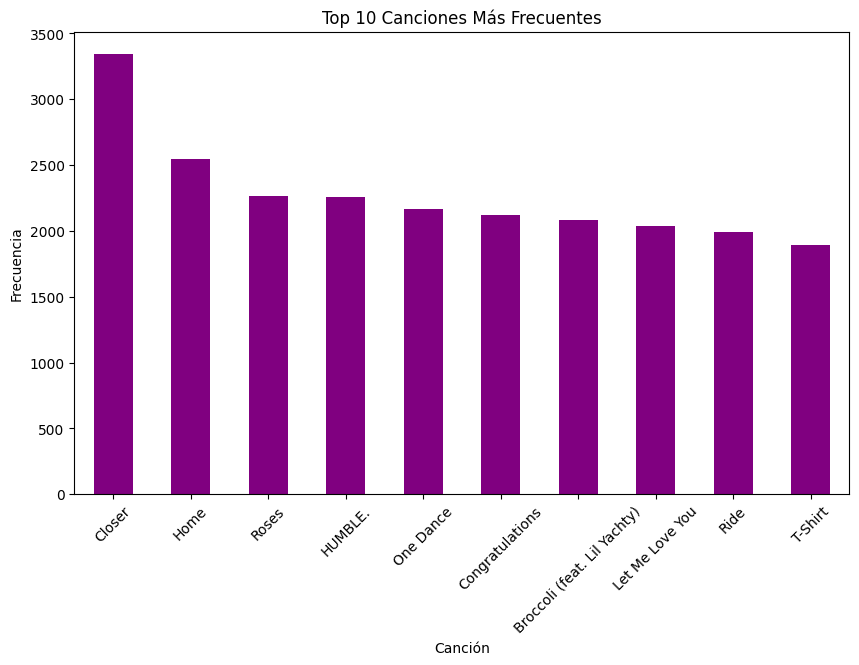

In [35]:
# Contar las canciones más frecuentes
canciones_frecuentes = df['track_nombre'].value_counts().head(10)

# Gráfico de barras
plt.figure(figsize=(10, 6))
canciones_frecuentes.plot(kind='bar', color='purple')
plt.title('Top 10 Canciones Más Frecuentes')
plt.xlabel('Canción')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()


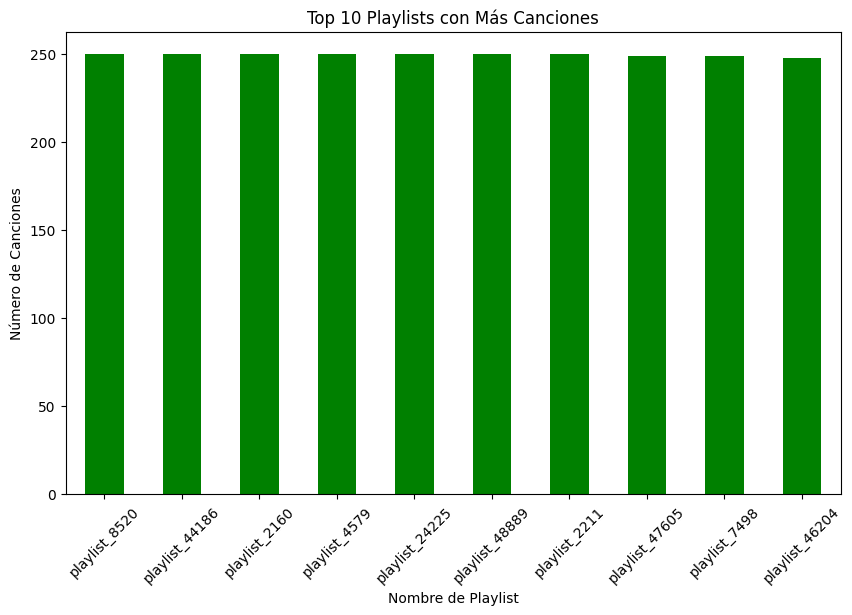

In [37]:
# Contar cuántas canciones tiene cada playlist
tamaño_playlist = df['playlist_nombre'].value_counts().head(10)

# Gráfico de barras
plt.figure(figsize=(10, 6))
tamaño_playlist.plot(kind='bar', color='green')
plt.title('Top 10 Playlists con Más Canciones')
plt.xlabel('Nombre de Playlist')
plt.ylabel('Número de Canciones')
plt.xticks(rotation=45)
plt.show()


En este gráfico de barras, se presentan las 10 playlists con mayor cantidad de canciones en el dataset de Spotify. Cada barra representa una playlist específica, y el eje vertical indica el número de canciones que contiene cada una. A continuación, se explican los hallazgos principales:

1. Uniformidad en el número de canciones: Todas las playlists en este gráfico tienen exactamente 250 canciones. Esto indica que estas playlists han sido creadas con el máximo número de canciones permitido o con un límite predefinido por los usuarios. Es posible que los creadores de estas playlists hayan buscado intencionalmente completar la playlist con 250 canciones, ya sea por razones estéticas o funcionales.

2. Playlists anónimas y sin contexto específico: Los nombres de las playlists en el eje horizontal están etiquetados con un formato genérico como playlist_8520, playlist_44186, etc., lo que indica que estas playlists podrían no tener un título descriptivo o identificable desde el punto de vista de su contenido. Esto sugiere que las playlists más grandes (en términos de número de canciones) pueden ser aquellas que se crean para maximizar la cantidad de música, sin necesariamente enfocarse en un tema, género o estilo específico.

3. Posible falta de variabilidad: El hecho de que todas las playlists más grandes contengan exactamente el mismo número de canciones sugiere una falta de variabilidad en este subconjunto de los datos. Esto puede indicar que las playlists más grandes tienden a alcanzar un límite superior de tamaño, y no hay una distribución amplia de tamaños entre las playlists que se encuentran en este rango superior.


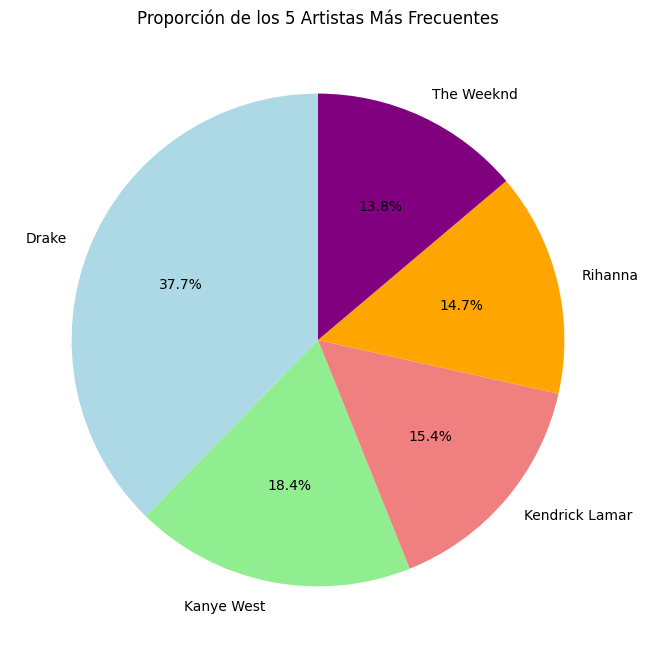

In [38]:
# Seleccionar los 5 artistas más comunes
artistas_frecuencia = df['artista_nombre'].value_counts().head(5)

# Gráfico circular
plt.figure(figsize=(8, 8))
artistas_frecuencia.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral', 'orange', 'purple'])
plt.title('Proporción de los 5 Artistas Más Frecuentes')
plt.ylabel('')  # Eliminar etiqueta del eje y
plt.show()


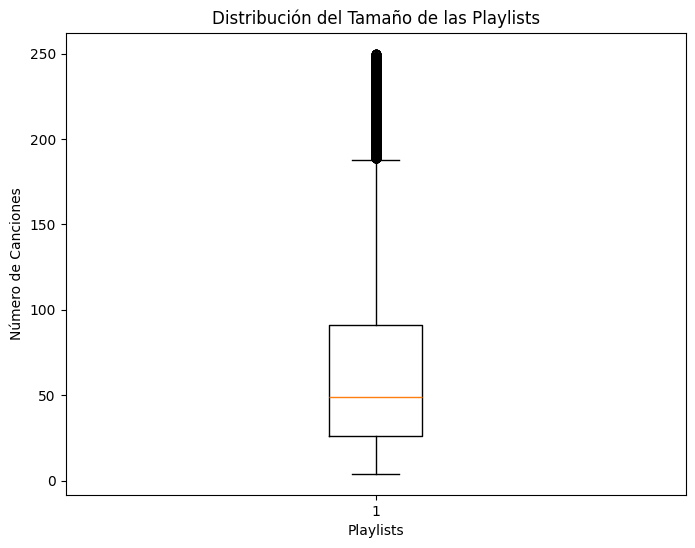

In [40]:
# Contar cuántas canciones tiene cada playlist
tamaño_playlist = df.groupby('playlist_nombre').size()

# Gráfico de cajas y bigotes para mostrar la distribución del tamaño de las playlists
plt.figure(figsize=(8, 6))
plt.boxplot(tamaño_playlist)
plt.title('Distribución del Tamaño de las Playlists')
plt.xlabel('Playlists')
plt.ylabel('Número de Canciones')
plt.show()


Este gráfico de cajas y bigotes visualiza la distribución del número de canciones en las playlists del dataset de Spotify. El boxplot es una herramienta útil para resumir de manera visual varios aspectos estadísticos clave de los datos, tales como la mediana, los cuartiles y los valores atípicos. A continuación, se detallan los principales puntos que este gráfico revela:

1. Mediana:
*  La línea naranja en el centro de la caja representa la mediana del número de canciones en las playlists. Según el gráfico, la mediana parece estar alrededor de 50 canciones por playlist. Esto significa que la mitad de las playlists tiene más de 50 canciones, y la otra mitad tiene menos.

2. Cuartiles 
* La caja central del gráfico muestra los valores correspondientes al primer cuartil (Q1) y el tercer cuartil (Q3). El rango intercuartílico (Q3 - Q1) indica que el número de canciones en el 50% central de las playlists se encuentra entre aproximadamente 25 y 100 canciones. Esto demuestra una considerable variabilidad en el tamaño de las playlists.

3. Bigotes 
* Los bigotes del gráfico se extienden desde los bordes de la caja hasta el valor máximo dentro de un rango de 1.5 veces el rango intercuartílico. En este caso, los bigotes alcanzan hasta aproximadamente 200 canciones. Sin embargo, cualquier playlist con más de 200 canciones se considera un valor atípico.

4. Valores atˆpicos (outlier)
* Los puntos negros por encima del bigote superior representan playlists que contienen más de 200 canciones, las cuales se consideran valores atípicos en este conjunto de datos. Estas playlists no son la norma y sugieren que algunos usuarios crean listas excepcionalmente largas, a pesar de que la mayoría de las playlists tienen menos canciones.